In [1]:
import pandas as pd

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [3]:
cols = ["a","b","c","d","e"]
df = pd.read_csv("./cluster_data.csv", usecols=cols)

In [4]:
df.head()

,a,b,c,d,e
0,0.202196,1.210328,-0.362121,6.774688,10.471171
1,-18.387879,6.307993,0.570526,-2.800453,0.791784
2,-0.353418,-2.519796,-1.434224,-2.460677,-1.848893
3,0.681851,-2.437309,-2.324559,-3.930883,0.126415
4,-1.398950,-0.306058,0.700491,1.280063,-0.367040


In [5]:
df.describe()

,a,b,c,d,e
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-1.408342,2.481644,1.640549,3.834483,3.381425
std,6.849860,3.897975,3.548427,6.822418,7.476862
min,-19.385151,-4.982372,-5.786045,-5.583204,-7.732816
25%,-2.663111,-0.448952,-0.614847,-0.459470,-0.688404
50%,0.078303,1.242171,0.614295,1.288900,0.756951
75%,1.536407,6.478028,4.317826,5.936949,4.703692
max,10.816078,10.217713,10.108888,22.114096,22.833183


For instance, parametric ones: you can fit a Gaussian Mixture Model by Expectation Maximization or Variational Bayes Inference; you test for different number of clusters and select the model that best fits your data. Be careful, model selection is not the same for a non-bayesian method (such as EM), where you have a point estimate of the clustering, than for a bayesian method such has VB where you have a full posterior distribution.

PyMC has a lodule for doing clustering

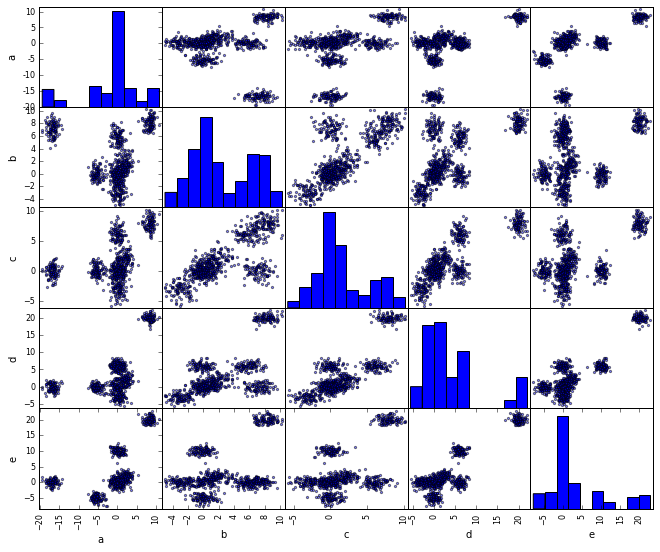

In [6]:
pd.scatter_matrix(df);

It might be worth visualising how the points are distributed. Each point exists in 5D-space. We can use a scatter matric to plot every dimension against every other dimension ... not sure how illuminating this is. 

How was the data generated? Looks like there are 5 (??) clusters and we could assign rouch 5-tuple coordinates.

We can try to model how this data was generated. 

  1. For each data point, choose cluster $i$ with probability $p_i$ (where we assume $\sum_i^N p_i = 1$.
  2. Draw a random variate from a Normal distribution with parameters $\mathbf{\mu_i}$ and $\sigma_i$ where $i$ was chosen in step 1.
  3. Rinse and repeat.

We must estimate 

In [62]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 12)

In [63]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [64]:
X = df.as_matrix()  # convert to numpy array
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [65]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

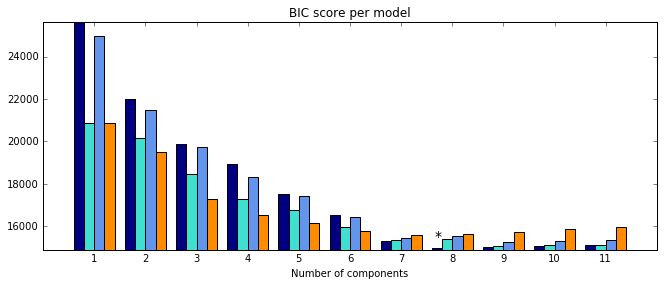

In [66]:
# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
# spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
# splot = plt.subplot(2, 1, 2)
# Y_ = clf.predict(X)
# for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
#                                            color_iter)):
#     v, w = linalg.eigh(cov)
#     if not np.any(Y_ == i):
#         continue
#     plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180. * angle / np.pi  # convert to degrees
#     v = 2. * np.sqrt(2.) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(.5)
#     splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
# plt.title('Selected GMM: full model, 2 components')
# plt.subplots_adjust(hspace=.35, bottom=.02)
# plt.show()

So we find the Gaussian Mixture model that best fits the data (as judged by a minimisation of the BIC criterion) is an 8 component spherical covariance gaussian. Spherical gaussian here means that the variance of each Gaussian is the same in all directions ie. symmetrical. I have to say this surpises me a bit; although its hard to picture things in 5D the scatter mtrix plot looks like some of the clusters take on cigar shapes when projected on to some dimensions. 

We could also take a Bayesian approach.



In [89]:
import pymc3 as pm
import theano.tensor as T

from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
from theano import tensor as T

blue = sns.color_palette()[0]

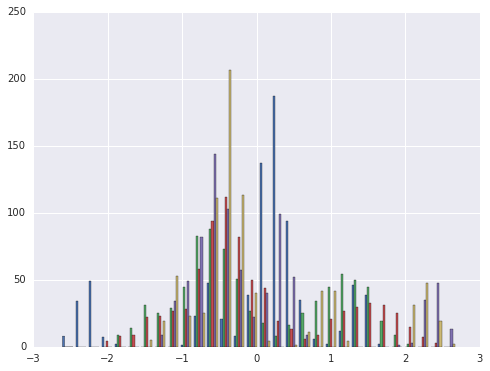

In [98]:
x_std = (X - X.mean(axis=0)) / X.std(axis=0)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x_std, bins=30);

In [107]:
K = 30
N_DIMS = 5
MU_0 = 1
# Dirichilet prior.
ALPHA_0 = np.ones(K)
# Component means prior.
MU_0 = np.zeros(N_DIMS)
LAMB_0 = 2. * np.eye(N_DIMS)

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
#     mu1 = pm.Normal('mu1', 0, tau=lambda_ * tau, shape=K)
#     mu2 = pm.Normal('mu2', 0, tau=lambda_ * tau, shape=K)
#     mu3 = pm.Normal('mu3', 0, tau=lambda_ * tau, shape=K)
#     mu4 = pm.Normal('mu4', 0, tau=lambda_ * tau, shape=K)
#     mu5 = pm.Normal('mu5', 0, tau=lambda_ * tau, shape=K)
#     mus = [mu1, mu2, mu3, mu4, mu5]
    mus = [pm.MvNormal('mu_{}'.format(i), MU_0, shape=N_DIMS) for i in range(K)]
    obs = pm.Mixture('obs', w, pm.MvNormal.dist(mus), observed=x_std)
#     obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
#                            observed=x_std)

with model:
    trace = pm.sample(2000, n_init=100000)

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(np.arange(K) - 0.4, trace['w'].mean(axis=0));

ValueError: Input dimension mis-match. (input[0].shape[1] = 30, input[1].shape[1] = 5)

In [114]:
import sys
import random
import pymc3 as pm
import numpy
from dendropy.mathlib import probability as prob
from dendropy.mathlib import statistics as stats

rng = random.Random()

##############################################################################
# supporting functions

def summarize(mcmc, field):
    results = mcmc.trace(field)[:]
    results = zip(*results)
    means = []
    for r in results:
        m, v = stats.mean_and_sample_variance(r)
        means.append(m)
    means.append(1.0 - sum(means))
    print
    print "---"
    print means

##############################################################################
# data

NUM_DRAWS = 100
NUM_SAMPLES = 50
TRUE_PROPS = [0.6, 0.3, 1.0]

def generate_data():
    data = []
    for i in range(NUM_SAMPLES):
        x = numpy.random.multinomial(NUM_DRAWS, TRUE_PROPS)
        data.append(x)
    return data

##############################################################################
# model

props = pm.Dirichlet(
        name="props",
        theta=[1.0, 1.0, 1.0],)
draws = pm.Multinomial(
        name="draws",
        value=generate_data(),
        n=NUM_DRAWS,
        p=props,
        observed=True)
mcmc = pm.MCMC([props, draws])
mcmc.sample(iter=100000, burn=10000, thin=100)
# mcmc.sample(iter=1000, burn=100, thin=1)
summarize(mcmc, "props")


TypeError: No model on context stack, which is needed to use the Normal('x', 0,1) syntax. Add a 'with model:' block

In [108]:
import numpy as np
import pymc3 as pm
import scipy
import theano
from theano import tensor


target_data = np.random.random((500, 16))

N_COMPONENTS = 5
N_SAMPLES, N_DIMS = target_data.shape

# Dirichilet prior.
ALPHA_0 = np.ones(N_COMPONENTS)
# Component means prior.
MU_0 = np.zeros(N_DIMS)
LAMB_0 = 1. * np.eye(N_DIMS)
# Components precision prior.
BETA_0, BETA_1 = 0., 1.    # Covariance stds prior uniform limits.
L_0 = 2.       # LKJ corr. shape. Larger shape -> more biased to identity.

# In order to convert the upper triangular correlation values to a
# complete correlation matrix, we need to construct an index matrix:
# Source: http://stackoverflow.com/q/29759789/1901296
N_ELEMS = N_DIMS * (N_DIMS - 1) / 2
tri_index = np.zeros([N_DIMS, N_DIMS], dtype=int)
tri_index[np.triu_indices(N_DIMS, k=1)] = np.arange(N_ELEMS)
tri_index[np.triu_indices(N_DIMS, k=1)[::-1]] = np.arange(N_ELEMS)

with pm.Model() as model:
    # Component weight prior.
    pi = pm.Dirichlet('pi', ALPHA_0, testval=np.ones(N_COMPONENTS) / N_COMPONENTS)
    #pi_potential = pm.Potential('pi_potential', tensor.switch(tensor.min(pi) < .01, -np.inf, 0))

    ###################
    # Components plate.
    ###################
    # Component means.
    mus = [pm.MvNormal('mu_{}'.format(i), MU_0, LAMB_0, shape=N_DIMS)
           for i in range(N_COMPONENTS)]

    # Component precisions.
    #lamb = diag(sigma) * corr(corr_shape) * diag(sigma)
    corr_vecs = [
            pm.LKJCorr('corr_vec_{}'.format(i), L_0, N_DIMS)
            for i in range(N_COMPONENTS)
    ]
    # Transform the correlation vector representations to matrices.
    corrs = [
        tensor.fill_diagonal(corr_vecs[i][tri_index], 1.)
        for i in range(N_COMPONENTS)
    ]
    # Stds for the correlation matrices.
    cov_stds = pm.Uniform('cov_stds', BETA_0, BETA_1, shape=(N_COMPONENTS, N_DIMS))
    # Finally re-compose the covariance matrices using diag(sigma) * corr * diag(sigma)
    # Source http://austinrochford.com/posts/2015-09-16-mvn-pymc3-lkj.html
    lambs = []
    for i in range(N_COMPONENTS):
        std_diag = tensor.diag(cov_stds[i])
        cov = std_diag.dot(corrs[i]).dot(std_diag)
        lambs.append(tensor.nlinalg.matrix_inverse(cov))

    stacked_mus = tensor.stack(mus)
    stacked_lambs = tensor.stack(lambs)

    #####################
    # Observations plate.
    #####################
    z = pm.Categorical('z', pi, shape=N_SAMPLES)

    @theano.as_op(itypes=[tensor.dmatrix, tensor.lvector, tensor.dmatrix, tensor.dtensor3],
                  otypes=[tensor.dscalar])
    def likelihood_op(values, z_values, mu_values, prec_values):
        logp = 0.
        for i in range(N_COMPONENTS):
            indices = z_values == i
            if not indices.any():
                continue

            logp += scipy.stats.multivariate_normal(
                mu_values[i], prec_values[i]).logpdf(values[indices])
        return logp

    def likelihood(values):
        return likelihood_op(values, z, stacked_mus, stacked_lambs)

    y = pm.DensityDist('y', likelihood, observed=target_data)

    step1 = pm.Metropolis(vars=mus + lambs + [pi])
    step2 = pm.ElemwiseCategoricalStep(vars=[z], values=list(range(N_COMPONENTS)))

    trace = pm.sample(100, step=[step1, step2])


TypeError: For compute_test_value, one input test value does not have the requested type.
 
Backtrace when that variable is created:
  File "/Users/cameron2/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/cameron2/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/cameron2/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-108-c492525b4350>", line 87, in <module>
    y = pm.DensityDist('y', likelihood, observed=target_data)
  File "/Users/cameron2/anaconda/lib/python2.7/site-packages/pymc3/distributions/distribution.py", line 31, in __new__
    return model.Var(name, dist, data)
  File "/Users/cameron2/anaconda/lib/python2.7/site-packages/pymc3/model.py", line 303, in Var
    distribution=dist, model=self)
  File "/Users/cameron2/anaconda/lib/python2.7/site-packages/pymc3/model.py", line 586, in __init__
    self.logp_elemwiset = distribution.logp(data)
  File "<ipython-input-108-c492525b4350>", line 85, in likelihood
    return likelihood_op(values, z, stacked_mus, stacked_lambs)

The error when converting the test value to that variable type:
Wrong number of dimensions: expected 0, got 1 with shape (500,).

In [ ]:
trace['mu'].mean(axis=0)[:4]

(array([  70.,   30.,    0.,    1.,   82.,   55.,  384.,   77.,   25.,   76.]),
 array([-19.38515144, -16.36502852, -13.34490561, -10.32478269,
         -7.30465978,  -4.28453686,  -1.26441395,   1.75570897,
          4.77583189,   7.7959548 ,  10.81607772]),
 <a list of 10 Patch objects>)

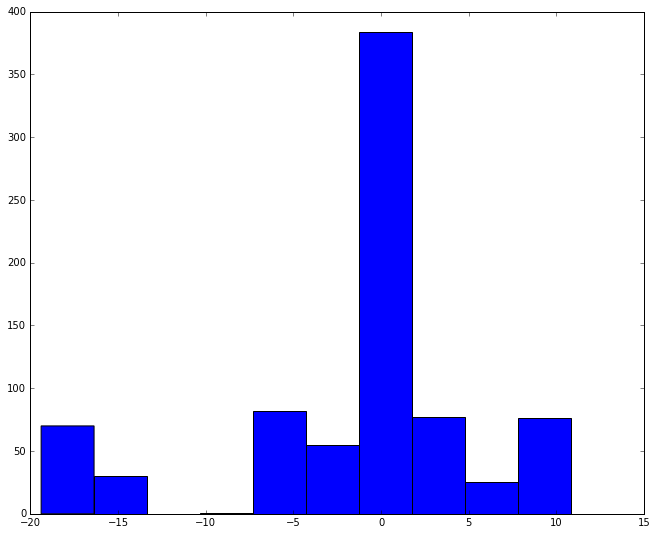

In [88]:

plt.hist(df.a)